# Paradigm 06: Experience Store Research Agent

This notebook implements the **Experience Store** paradigm from the Research Paradigms document.

## Core Concept

The Experience Store enables non-parametric learning through case-based reasoning:
- **Case Storage**: Store successful research trajectories and outcomes
- **Case Retrieval**: Find similar past cases for new queries
- **Strategy Adaptation**: Apply learned strategies to new problems

## Literature Validation

> "DS-Agent, Agent K, AgentRxiv... demonstrate non-parametric learning through experience storage, achieving 21 gold medals in Kaggle competitions through stored strategies." —Feasibility Report

## Technology Stack

- **LLM**: `gpt-5-mini-2025-08-07`
- **Web Search**: Tavily API
- **Tracing**: LangSmith
- **Framework**: LangGraph
- **Case Storage**: In-memory dictionary (MVP)

## 1. Setup and Configuration

In [1]:
import os
import operator
import asyncio
import hashlib
import json
from pathlib import Path
from typing import List, Annotated, TypedDict, Literal, Optional, Dict, Any
from datetime import datetime

from dotenv import load_dotenv
from pydantic import BaseModel, Field

from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage
from tavily import TavilyClient

from langgraph.graph import StateGraph, START, END

# Load environment variables
env_path = Path("../.env")
load_dotenv(env_path)

# Configure LangSmith tracing
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "deep_research_new"

print("Environment configured successfully")

Environment configured successfully


In [2]:
# Initialize LLM and Tavily client
MODEL_NAME = "gpt-5-mini-2025-08-07"
# Configure LLM with retry settings
llm = ChatOpenAI(
    model=MODEL_NAME, 
    temperature=0,
    max_retries=10  # Retry up to 5 times
)
tavily_client = TavilyClient()

# Experience Store Configuration
EXPERIENCE_STORE_PATH = Path("../data/experience_store.json")
MAX_RETRIEVED_CASES = 3  # Number of similar cases to retrieve
SIMILARITY_THRESHOLD = 0.2  # Minimum similarity for case retrieval (lowered for better recall)
MIN_QUALITY_FOR_STORAGE = 5.0  # Only store cases with quality >= this threshold

print(f"Using model: {MODEL_NAME}")
print(f"Experience store: {EXPERIENCE_STORE_PATH}")
print(f"Max retrieved cases: {MAX_RETRIEVED_CASES}")
print(f"Min quality for storage: {MIN_QUALITY_FOR_STORAGE}")

Using model: gpt-5-mini-2025-08-07
Experience store: ..\data\experience_store.json
Max retrieved cases: 3
Min quality for storage: 5.0


## 2. Experience Store Implementation

In [3]:
class ExperienceCase(BaseModel):
    """A stored experience case."""
    case_id: str = Field(description="Unique case identifier")
    question: str = Field(description="The research question")
    category: str = Field(default="general", description="Question category")
    keywords: List[str] = Field(default_factory=list, description="Key terms")
    successful_strategies: List[str] = Field(default_factory=list, description="What worked")
    search_queries: List[str] = Field(default_factory=list, description="Effective queries")
    report_structure: List[str] = Field(default_factory=list, description="Section structure")
    quality_score: float = Field(default=0.0, description="Final quality score")
    timestamp: str = Field(default="", description="When this case was created")

In [4]:
class ExperienceStore:
    """In-memory experience store with persistence and intelligent retrieval."""
    
    def __init__(self, store_path: Path):
        self.store_path = store_path
        self.cases: Dict[str, ExperienceCase] = {}
        self._load()
    
    def _load(self):
        """Load cases from disk."""
        if self.store_path.exists():
            try:
                with open(self.store_path, 'r') as f:
                    data = json.load(f)
                    for case_id, case_data in data.items():
                        self.cases[case_id] = ExperienceCase(**case_data)
                print(f"Loaded {len(self.cases)} cases from experience store")
            except Exception as e:
                print(f"Error loading experience store: {e}")
                self.cases = {}
        else:
            print("No existing experience store found. Starting fresh.")
    
    def _save(self):
        """Save cases to disk."""
        try:
            self.store_path.parent.mkdir(parents=True, exist_ok=True)
            with open(self.store_path, 'w') as f:
                data = {k: v.model_dump() for k, v in self.cases.items()}
                json.dump(data, f, indent=2)
        except Exception as e:
            print(f"Error saving experience store: {e}")
    
    def _generate_case_id(self, question: str) -> str:
        """Generate unique case ID from question."""
        return hashlib.md5(question.encode()).hexdigest()[:12]
    
    def _calculate_similarity(self, query_keywords: List[str], query_category: str, 
                             case: ExperienceCase) -> float:
        """Calculate similarity considering keywords AND category.
        
        Returns weighted score: 70% keyword similarity + 30% category match
        """
        if not query_keywords or not case.keywords:
            keyword_sim = 0.0
        else:
            # Normalize keywords for better matching
            query_set = set(kw.lower().strip() for kw in query_keywords)
            case_set = set(kw.lower().strip() for kw in case.keywords)
            
            intersection = len(query_set & case_set)
            union = len(query_set | case_set)
            keyword_sim = intersection / union if union > 0 else 0.0
        
        # Category match bonus
        category_match = 1.0 if query_category.lower() == case.category.lower() else 0.0
        
        # Weighted combination
        return 0.7 * keyword_sim + 0.3 * category_match
    
    def store_case(self, case: ExperienceCase) -> Optional[str]:
        """Store a new experience case if it meets quality threshold.
        
        Returns case_id if stored, None if rejected due to low quality.
        """
        # Quality gate: don't store low-quality experiences
        if case.quality_score < MIN_QUALITY_FOR_STORAGE:
            print(f"  Case rejected: quality {case.quality_score:.1f} < threshold {MIN_QUALITY_FOR_STORAGE}")
            return None
        
        if not case.case_id:
            case.case_id = self._generate_case_id(case.question)
        if not case.timestamp:
            case.timestamp = datetime.now().isoformat()
        
        self.cases[case.case_id] = case
        self._save()
        
        return case.case_id
    
    def retrieve_similar(self, keywords: List[str], category: str = "general", 
                        max_cases: int = 3, min_quality: float = 6.0) -> List[ExperienceCase]:
        """Retrieve similar HIGH-QUALITY cases based on keywords and category.
        
        Args:
            keywords: Query keywords for matching
            category: Query category for matching
            max_cases: Maximum cases to return
            min_quality: Minimum quality score for retrieved cases
        """
        if not self.cases:
            return []
        
        scored_cases = []
        for case in self.cases.values():
            # Filter by minimum quality
            if case.quality_score < min_quality:
                continue
                
            similarity = self._calculate_similarity(keywords, category, case)
            if similarity >= SIMILARITY_THRESHOLD:
                scored_cases.append((similarity, case))
        
        # Sort by similarity first, then by quality score
        scored_cases.sort(key=lambda x: (x[0], x[1].quality_score), reverse=True)
        
        return [case for _, case in scored_cases[:max_cases]]
    
    def get_best_queries_for_category(self, category: str, top_n: int = 10) -> List[str]:
        """Get the most effective search queries from high-quality cases in a category."""
        relevant_cases = [c for c in self.cases.values() 
                        if c.category.lower() == category.lower() and c.quality_score >= 7.0]
        
        if not relevant_cases:
            return []
        
        # Collect queries from highest quality cases
        relevant_cases.sort(key=lambda c: c.quality_score, reverse=True)
        queries = []
        for case in relevant_cases[:5]:  # Top 5 cases
            queries.extend(case.search_queries[:3])  # Top 3 queries per case
        
        return queries[:top_n]
    
    def get_stats(self) -> dict:
        """Get store statistics."""
        if not self.cases:
            return {"total_cases": 0}
        
        scores = [c.quality_score for c in self.cases.values()]
        categories = list(set(c.category for c in self.cases.values()))
        high_quality = len([s for s in scores if s >= 7.0])
        
        return {
            "total_cases": len(self.cases),
            "high_quality_cases": high_quality,
            "avg_quality": sum(scores) / len(scores) if scores else 0,
            "categories": categories
        }

# Initialize global experience store
experience_store = ExperienceStore(EXPERIENCE_STORE_PATH)
print(f"Store stats: {experience_store.get_stats()}")

No existing experience store found. Starting fresh.
Store stats: {'total_cases': 0}


## 3. State Definitions

In [5]:
class ExperienceStoreState(TypedDict):
    """State for the Experience Store Research Agent."""
    # Input
    question: str
    
    # Experience retrieval
    query_keywords: List[str]
    query_category: str  # NEW: Extracted category for better matching
    retrieved_cases: List[dict]  # Serialized ExperienceCase objects
    adapted_strategy: str
    proven_queries: List[str]  # NEW: Effective queries from past cases
    
    # Research execution
    search_queries: List[str]
    search_results: Annotated[List[str], operator.add]
    source_urls: Annotated[List[str], operator.add]
    
    # Report
    report_structure: List[str]
    final_report: str
    quality_score: float
    
    # Case creation
    successful_strategies: List[str]

## 4. Helper Functions

In [6]:
def search_web(query: str, max_results: int = 10) -> tuple[List[str], List[str]]:
    """Execute web search using Tavily. Returns (results, urls)."""
    try:
        if len(query) > 400:
            query = query[:400]
        
        response = tavily_client.search(
            query=query,
            max_results=max_results,
            include_answer=True
        )
        
        results = []
        urls = []
        
        if response.get("answer"):
            results.append(f"Summary: {response['answer']}")
        
        for r in response.get("results", []):
            url = r.get('url', '')
            urls.append(url)
            results.append(f"- {r.get('title', 'No title')}: {r.get('content', '')[:500]}... (Source: {url})")
        
        return results, urls
    except Exception as e:
        return [f"Search error: {str(e)}"], []

## 5. Node Functions

In [7]:
# Prompts
EXTRACT_KEYWORDS_PROMPT = """Analyze this research question and extract:
1. CATEGORY: One of [technology, science, business, policy, health, economics, environment, social, history, general]
2. KEYWORDS: 5-10 key terms that capture the main concepts

Question: {question}

Format your response EXACTLY as:
CATEGORY: [category]
KEYWORDS:
- keyword1
- keyword2
...
"""

ADAPT_STRATEGY_PROMPT = """You are adapting successful research strategies from similar past cases.

Current Question: {question}

Similar Past Cases:
{past_cases}

Proven Search Queries from Past Successes:
{proven_queries}

Based on these past successes, provide a SPECIFIC strategy:
1. Which search query patterns worked well? Adapt them for this question.
2. What report structure was effective? Map it to this question's needs.
3. What pitfalls to avoid based on lower-quality cases?

Be specific and actionable. Reference the proven queries directly.
"""

GENERATE_QUERIES_PROMPT = """Generate search queries for this research question.

Question: {question}

Strategy guidance from past experience:
{strategy}

PROVEN queries from similar successful cases (adapt these patterns):
{proven_queries}

Generate 5-7 effective search queries. 
- Use patterns from the proven queries
- Adapt successful phrasing for this specific question
- Include both broad and specific queries

Return ONLY the search queries, one per line.
"""

WRITE_REPORT_PROMPT = """Write a comprehensive research report.

Question: {question}

Strategy guidance:
{strategy}

Suggested structure:
{structure}

Research Findings:
{findings}

Write a detailed report (1000-1500 words) following the suggested structure.
Include citations and evidence from the research.
"""

EVALUATE_REPORT_PROMPT = """Evaluate this research report on a scale of 1-10.

Question: {question}

Report:
{report}

Rate on:
1. Relevance to question (1-10)
2. Evidence quality (1-10)
3. Coherence (1-10)
4. Completeness (1-10)

Respond with ONLY four numbers separated by commas (e.g., "8, 7, 9, 8").
"""

EXTRACT_STRATEGIES_PROMPT = """Analyze what made this research successful and extract specific, reusable strategies.

Question: {question}
Quality Score: {quality_score}/10

Search Queries Used:
{queries}

Report Summary (first 500 chars):
{report_summary}

Extract 2-4 SPECIFIC strategies that worked. Be concrete, not generic.
Bad: "Used comprehensive searches"
Good: "Combined [topic] with 'recent developments' for timely results"

Return each strategy on a new line starting with "- ".
"""

In [8]:
import re

def parse_keywords_response(response: str) -> tuple[str, List[str]]:
    """Parse the category and keywords from the LLM response."""
    category = "general"
    keywords = []
    
    # Extract category
    cat_match = re.search(r'CATEGORY:\s*(\w+)', response, re.IGNORECASE)
    if cat_match:
        category = cat_match.group(1).lower()
    
    # Extract keywords
    keyword_section = re.search(r'KEYWORDS:\s*\n(.*)', response, re.DOTALL | re.IGNORECASE)
    if keyword_section:
        lines = keyword_section.group(1).split('\n')
        for line in lines:
            line = line.strip()
            if line.startswith('-'):
                kw = line[1:].strip()
                if kw:
                    keywords.append(kw)
            elif line and not line.startswith('CATEGORY'):
                keywords.append(line)
    
    return category, keywords[:10]  # Max 10 keywords


async def extract_keywords(state: ExperienceStoreState) -> dict:
    """Extract keywords AND category from the question for case retrieval."""
    question = state["question"]
    
    print(f"\n{'='*60}")
    print(f"Experience Store: Analyzing Question")
    print(f"{'='*60}")
    
    prompt = EXTRACT_KEYWORDS_PROMPT.format(question=question)
    response = await llm.ainvoke([HumanMessage(content=prompt)])
    
    category, keywords = parse_keywords_response(response.content)
    
    print(f"  Category: {category}")
    print(f"  Keywords: {keywords[:5]}{'...' if len(keywords) > 5 else ''}")
    
    return {
        "query_keywords": keywords,
        "query_category": category
    }

In [9]:
async def retrieve_cases(state: ExperienceStoreState) -> dict:
    """Retrieve similar cases from experience store using keywords AND category."""
    keywords = state.get("query_keywords", [])
    category = state.get("query_category", "general")
    
    print(f"\n--- Retrieving Similar Cases ---")
    print(f"  Searching for category: {category}")
    
    # Retrieve similar cases (now with category matching and quality filtering)
    similar_cases = experience_store.retrieve_similar(
        keywords=keywords, 
        category=category, 
        max_cases=MAX_RETRIEVED_CASES,
        min_quality=6.0  # Only retrieve high-quality cases
    )
    
    # Also get proven queries from the category
    proven_queries = experience_store.get_best_queries_for_category(category)
    
    if similar_cases:
        print(f"  Found {len(similar_cases)} similar high-quality cases:")
        for case in similar_cases:
            print(f"    - [{case.category}] {case.question[:40]}... (score: {case.quality_score:.1f})")
    else:
        print("  No similar high-quality cases found. Starting fresh.")
    
    if proven_queries:
        print(f"  Found {len(proven_queries)} proven queries from category '{category}'")
    
    # Serialize cases for state
    serialized = [case.model_dump() for case in similar_cases]
    
    return {
        "retrieved_cases": serialized,
        "proven_queries": proven_queries
    }

In [10]:
async def adapt_strategy(state: ExperienceStoreState) -> dict:
    """Adapt strategies from retrieved cases, including proven queries."""
    question = state["question"]
    retrieved_cases = state.get("retrieved_cases", [])
    proven_queries = state.get("proven_queries", [])
    
    print(f"\n--- Adapting Strategy ---")
    
    if not retrieved_cases and not proven_queries:
        # Default strategy if no experience available
        strategy = "No prior experience available. Use standard research approach with diverse search queries."
        structure = ["Introduction", "Background", "Analysis", "Key Findings", "Conclusion"]
        print("  Using default strategy (no prior experience)")
    else:
        # Format past cases for LLM
        cases_text = ""
        for i, case in enumerate(retrieved_cases, 1):
            cases_text += f"\nCase {i}: {case['question'][:100]}...\n"
            cases_text += f"  Category: {case.get('category', 'unknown')}\n"
            cases_text += f"  Strategies: {', '.join(case.get('successful_strategies', [])[:3])}\n"
            cases_text += f"  Structure: {', '.join(case.get('report_structure', [])[:5])}\n"
            cases_text += f"  Quality: {case.get('quality_score', 0):.1f}/10\n"
        
        # Format proven queries
        queries_text = "\n".join([f"- {q}" for q in proven_queries[:10]]) if proven_queries else "None available"
        
        prompt = ADAPT_STRATEGY_PROMPT.format(
            question=question,
            past_cases=cases_text if cases_text else "None available",
            proven_queries=queries_text
        )
        
        response = await llm.ainvoke([HumanMessage(content=prompt)])
        strategy = response.content
        
        # Extract structure from best case
        if retrieved_cases:
            best_case = max(retrieved_cases, key=lambda c: c.get('quality_score', 0))
            structure = best_case.get('report_structure', ["Introduction", "Analysis", "Conclusion"])
        else:
            structure = ["Introduction", "Background", "Analysis", "Key Findings", "Conclusion"]
        
        print(f"  Strategy adapted from {len(retrieved_cases)} cases + {len(proven_queries)} proven queries")
    
    return {
        "adapted_strategy": strategy,
        "report_structure": structure
    }

In [11]:
async def execute_research(state: ExperienceStoreState) -> dict:
    """Execute research with adapted strategy and proven queries."""
    question = state["question"]
    strategy = state.get("adapted_strategy", "")
    proven_queries = state.get("proven_queries", [])
    
    print(f"\n--- Executing Research ---")
    
    # Format proven queries for the prompt
    proven_queries_text = "\n".join([f"- {q}" for q in proven_queries[:6]]) if proven_queries else "None available"
    
    # Generate queries using strategy AND proven queries
    prompt = GENERATE_QUERIES_PROMPT.format(
        question=question,
        strategy=strategy[:500],
        proven_queries=proven_queries_text
    )
    
    response = await llm.ainvoke([HumanMessage(content=prompt)])
    queries = [q.strip() for q in response.content.split("\n") if q.strip()][:7]
    
    # Execute searches
    all_results = []
    all_urls = []
    
    for query in queries:
        print(f"  Searching: {query[:50]}...")
        results, urls = search_web(query)
        all_results.extend(results)
        all_urls.extend(urls)
    
    print(f"  Collected {len(all_results)} results from {len(set(all_urls))} sources")
    
    return {
        "search_queries": queries,
        "search_results": all_results,
        "source_urls": all_urls
    }

In [12]:
async def write_report(state: ExperienceStoreState) -> dict:
    """Write report using adapted structure."""
    question = state["question"]
    strategy = state.get("adapted_strategy", "")
    structure = state.get("report_structure", [])
    search_results = state.get("search_results", [])
    
    print(f"\n--- Writing Report ---")
    
    # Token efficiency: limit by character count, not just item count
    results_for_report = []
    total_chars = 0
    for result in search_results:
        if total_chars + len(result) > 10000:  # ~10k chars max
            break
        results_for_report.append(result)
        total_chars += len(result)
    
    print(f"  Using {len(results_for_report)}/{len(search_results)} results ({total_chars} chars)")
    
    prompt = WRITE_REPORT_PROMPT.format(
        question=question,
        strategy=strategy[:500],
        structure="\n".join(f"- {s}" for s in structure),
        findings="\n\n".join(results_for_report)
    )
    
    response = await llm.ainvoke([HumanMessage(content=prompt)])
    
    print(f"  Report generated: {len(response.content)} chars")
    
    return {
        "final_report": response.content
    }

In [13]:
async def evaluate_and_store(state: ExperienceStoreState) -> dict:
    """Evaluate report and store experience (if quality meets threshold)."""
    question = state["question"]
    report = state.get("final_report", "")
    keywords = state.get("query_keywords", [])
    category = state.get("query_category", "general")
    queries = state.get("search_queries", [])
    structure = state.get("report_structure", [])
    
    print(f"\n--- Evaluating and Storing Experience ---")
    
    # Evaluate report
    eval_prompt = EVALUATE_REPORT_PROMPT.format(
        question=question,
        report=report[:3000]  # Token efficiency
    )
    
    response = await llm.ainvoke([HumanMessage(content=eval_prompt)])
    
    # Parse scores
    try:
        scores = [float(s.strip()) for s in response.content.split(",")][:4]
        quality_score = sum(scores) / len(scores)
    except:
        quality_score = 6.0
        scores = [6, 6, 6, 6]
    
    print(f"  Quality scores: {scores}")
    print(f"  Average: {quality_score:.1f}/10")
    
    # Extract SPECIFIC strategies using LLM (not generic ones)
    strategies = []
    if quality_score >= 6.0:
        strategy_prompt = EXTRACT_STRATEGIES_PROMPT.format(
            question=question,
            quality_score=quality_score,
            queries="\n".join([f"- {q}" for q in queries]),
            report_summary=report[:500]
        )
        
        strategy_response = await llm.ainvoke([HumanMessage(content=strategy_prompt)])
        
        # Parse strategies
        for line in strategy_response.content.split("\n"):
            line = line.strip()
            if line.startswith("-"):
                strategy = line[1:].strip()
                if strategy and len(strategy) > 10:  # Filter out too-short strategies
                    strategies.append(strategy)
        
        strategies = strategies[:4]  # Max 4 strategies
        print(f"  Extracted {len(strategies)} specific strategies")
    
    # Create case (store_case will apply quality threshold)
    case = ExperienceCase(
        case_id="",
        question=question,
        category=category,  # Now using extracted category
        keywords=keywords,
        successful_strategies=strategies,
        search_queries=queries,
        report_structure=structure,
        quality_score=quality_score
    )
    
    case_id = experience_store.store_case(case)  # Returns None if below threshold
    
    if case_id:
        print(f"  Stored as case: {case_id}")
    else:
        print(f"  Case NOT stored (quality {quality_score:.1f} < threshold {MIN_QUALITY_FOR_STORAGE})")
    
    print(f"  Total cases in store: {len(experience_store.cases)}")
    print(f"  Store stats: {experience_store.get_stats()}")
    
    return {
        "quality_score": quality_score,
        "successful_strategies": strategies
    }

## 6. Graph Construction

In [14]:
# Build the Experience Store Research Agent graph
#
# Key improvements over naive case-based reasoning:
# 1. Category extraction and matching - questions matched to similar domains
# 2. Quality-gated storage - only high-quality cases stored (no pollution)
# 3. Quality-gated retrieval - only learn from successful experiences
# 4. Proven query reuse - directly leverage search patterns that worked
# 5. Specific strategy extraction - not generic "used searches" but actual patterns

es_builder = StateGraph(ExperienceStoreState)

# Add nodes
es_builder.add_node("extract_keywords", extract_keywords)
es_builder.add_node("retrieve_cases", retrieve_cases)
es_builder.add_node("adapt_strategy", adapt_strategy)
es_builder.add_node("execute_research", execute_research)
es_builder.add_node("write_report", write_report)
es_builder.add_node("evaluate_and_store", evaluate_and_store)

# Add edges - linear flow
es_builder.add_edge(START, "extract_keywords")
es_builder.add_edge("extract_keywords", "retrieve_cases")
es_builder.add_edge("retrieve_cases", "adapt_strategy")
es_builder.add_edge("adapt_strategy", "execute_research")
es_builder.add_edge("execute_research", "write_report")
es_builder.add_edge("write_report", "evaluate_and_store")
es_builder.add_edge("evaluate_and_store", END)

# Compile
experience_store_graph = es_builder.compile()

print("Experience Store Research Agent compiled successfully")
print("\nKey features:")
print("  - Category-aware case matching")
print("  - Quality-gated storage (min score: {})".format(MIN_QUALITY_FOR_STORAGE))
print("  - Proven query reuse from successful cases")
print("  - Specific strategy extraction (not generic)")
print("  - Experience improves over time as store grows")

Experience Store Research Agent compiled successfully

Key features:
  - Category-aware case matching
  - Quality-gated storage (min score: 5.0)
  - Proven query reuse from successful cases
  - Specific strategy extraction (not generic)
  - Experience improves over time as store grows


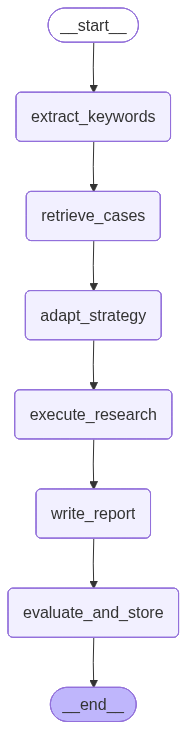

In [15]:
# Visualize the graph
from IPython.display import Image, display

try:
    display(Image(experience_store_graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Could not display graph: {e}")

## 7. Agent Wrapper for Evaluation

In [16]:
async def experience_store_agent_async(inputs: dict) -> dict:
    """
    Async version of the Experience Store research agent.
    Use this version when calling from Jupyter notebooks.
    """
    question = inputs.get("question", "")
    
    result = await experience_store_graph.ainvoke(
        {"question": question},
        config={"recursion_limit": 50}
    )
    
    return {
        "output": result.get("final_report", ""),
        "quality_score": result.get("quality_score", 0),
        "retrieved_cases": len(result.get("retrieved_cases", [])),
        "source_urls": list(set(result.get("source_urls", []))),  # Deduplicated
        "category": result.get("query_category", "general"),
        "strategies_learned": result.get("successful_strategies", [])
    }


def experience_store_agent(inputs: dict) -> dict:
    """
    Sync wrapper function for Experience Store research agent.
    
    Compatible with evaluation harness.
    
    Args:
        inputs: Dictionary with 'question' key
        
    Returns:
        Dictionary with 'output' key containing final report
    """
    question = inputs.get("question", "")
    
    async def _execute():
        return await experience_store_graph.ainvoke(
            {"question": question},
            config={"recursion_limit": 50}
        )
    
    # Check if we're already in an async context (e.g., Jupyter notebook)
    try:
        loop = asyncio.get_running_loop()
        # We're in an event loop - need to run in a separate thread
        import concurrent.futures
        with concurrent.futures.ThreadPoolExecutor() as executor:
            future = executor.submit(asyncio.run, _execute())
            result = future.result()
    except RuntimeError:
        # No event loop running, safe to use asyncio.run
        result = asyncio.run(_execute())
    
    return {
        "output": result.get("final_report", ""),
        "quality_score": result.get("quality_score", 0),
        "retrieved_cases": len(result.get("retrieved_cases", [])),
        "source_urls": list(set(result.get("source_urls", []))),  # Deduplicated
        "category": result.get("query_category", "general"),
        "strategies_learned": result.get("successful_strategies", [])
    }

## 8. Manual Test

Run this cell to verify the agent works correctly with a simple test question.

In [ ]:
# Simple test
test_question = "What are the key benefits and challenges of using large language models in enterprise applications?"

print(f"Testing Experience Store Agent with question:\n{test_question}\n")
print("Running experience-guided research (this may take several minutes)...\n")

try:
    # Use the async version in notebooks to avoid event loop conflicts
    result = await experience_store_agent_async({"question": test_question})
    
    print("\n" + "=" * 80)
    print("FINAL REPORT")
    print("=" * 80)
    print(result["output"][:3000] + "..." if len(result["output"]) > 3000 else result["output"])
    print("\n" + "=" * 80)
    print(f"Report length: {len(result['output'])} characters")
    print(f"Quality score: {result.get('quality_score', 0):.1f}/10")
    print(f"Similar cases used: {result.get('retrieved_cases', 0)}")
    print(f"Unique sources: {len(set(result.get('source_urls', [])))}")
    print(f"\nExperience Store Stats: {experience_store.get_stats()}")
    print("Agent test PASSED ✓")
except Exception as e:
    print(f"Agent test FAILED: {e}")
    import traceback
    traceback.print_exc()
    raise

## 9. Evaluation Harness Integration

Once the manual test passes, uncomment and run the cells below for full evaluation.

In [ ]:
# Import evaluation harness and metrics
import sys
sys.path.insert(0, "..")
from evaluation import (
    ExperimentHarness, 
    fact_recall, 
    citation_precision,
    coherence_judge, 
    depth_judge, 
    relevance_judge,
    minimum_sources_check
)

# Initialize harness with the golden test dataset
harness = ExperimentHarness(
    dataset_path="../data/deep_research_agent_test_dataset.yaml",
    langsmith_dataset_name="deep-research-golden-v2"
)

print("Evaluation harness initialized successfully!")
print(f"Dataset: {harness.dataset_path}")
print(f"LangSmith dataset name: {harness.langsmith_dataset_name}")

In [ ]:
# Full Evaluation on All 20 Questions
# ⚠️ EXPENSIVE - Only uncomment when ready for full evaluation
# NOTE: The Experience Store improves over time as it accumulates cases.
# Running the full evaluation will populate the store with experiences.
# Uncomment to run:

# # Define comprehensive evaluator suite
# evaluators = [
#     fact_recall,              # Required facts coverage
#     citation_precision,       # Citation URL validity
#     minimum_sources_check,    # Minimum source count
#     coherence_judge,          # Logical structure
#     depth_judge,              # Analysis depth
#     relevance_judge,          # Addresses question
# ]
# 
# # Run full evaluation
# print("Starting FULL evaluation on all 20 questions...")
# print("Experience Store Agent - this will take 1-2 hours.")
# print(f"Starting with {len(experience_store.cases)} existing cases.")
# print("=" * 80 + "\n")
# 
# results = harness.run_evaluation(
#     agent_fn=experience_store_agent,
#     evaluators=evaluators,
#     experiment_name="experience_store_v1",
#     monte_carlo_runs=1,  # Single run to reduce cost
#     max_concurrency=2,   # Lower concurrency for stability
#     description="Experience Store paradigm evaluation on all difficulty tiers"
# )
# 
# # Display comprehensive results
# print("\n" + "=" * 80)
# print("FULL EVALUATION RESULTS")
# print("=" * 80)
# print(f"Experiment: {results.experiment_name}")
# print(f"Questions evaluated: {results.num_questions}")
# print(f"Runs per question: {results.num_runs}")
# print(f"\nExperience Store now contains: {len(experience_store.cases)} cases")
# 
# print(f"\n{'Metric':<30} {'Mean':<10}")
# print("-" * 40)
# for metric_name in sorted(results.metrics.keys()):
#     if not metric_name.endswith('_std'):
#         value = results.metrics.get(metric_name, 0)
#         print(f"{metric_name:<30} {value:<10.3f}")
# 
# # Save results to file
# import json
# from datetime import datetime
# 
# results_file = Path("../results") / f"experience_store_results_{datetime.now().strftime('%Y%m%d_%H%M%S')}.json"
# results_file.parent.mkdir(exist_ok=True)
# 
# with open(results_file, 'w') as f:
#     json.dump({
#         "experiment_name": results.experiment_name,
#         "num_questions": results.num_questions,
#         "num_runs": results.num_runs,
#         "metrics": results.metrics,
#         "per_question": results.per_question_results,
#         "final_store_size": len(experience_store.cases)
#     }, f, indent=2)
# 
# print(f"\nResults saved to: {results_file}")

print("Full evaluation cell ready. Uncomment to run when ready.")